# Penny-shaped (radial) crack under uniform tension - displacement discontinuity solution

3D Elastic problem 

Solution for the displacement discontinuity of a flat penny-shaped crack  $ r \in [0,a], \theta \in [0,2\pi] $ under pure tensile loading $\sigma$.

Solution of the hyper-singular traction collocation BEM via an iterative solver using Triangular 0 order element so-called T0.


The analytical solution for the  crack displacement discontinuity is given  for $ r \in [0,a], \theta \in [0,2\pi]  $ as:

$\Delta u_z (r,\theta,z=0)= u_z (r,\theta,z=0^+)-u_z(r,\theta,z=0^-)=  \frac{8 \sigma}{ \pi E^\prime} \sqrt{a^2-r^2} =\frac{4 (1-\nu) \sigma}{\pi G} \sqrt{a^2-r^2}  $ 

$\Delta u_r (r,\theta,z=0)= \Delta u_\theta (r,\theta,z=0)= 0 $ 

where $E^\prime = E / (1-\nu^2) $ is the plane strain Young's modulus, $G = E/ (2(1+\nu)) $ the shear modulus, $E$ the Young's modulus and $\nu$ the Poisson's ratio.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

# %% importing BigWham 

from bigwham4py import BEMatrix

# load the analytical solution 
sys.path.append(os.path.join(os.getcwd(), '../../'))

from solutions.penny_shaped_crack_uniform import width


In [2]:
#Elastic properties
G=1.
nu=0.15

rr =np.linspace(0.00001,10.,1000)

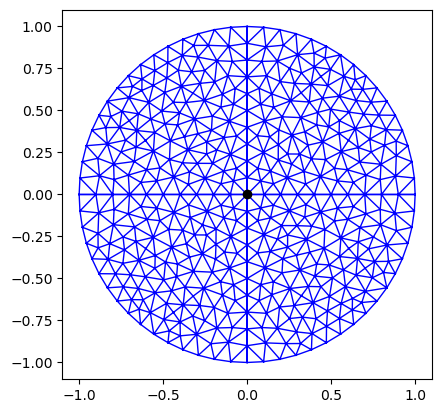

In [3]:
#%% mesh a circle with gmsh with a refinement in the center.
import pygmsh

center_res = 0.1
out_res = 0.1
Lx_ext = 1.

#   HERE 'wrong' ORIENTATION -> left hand rule .... 
with pygmsh.geo.Geometry() as geom:
    center_point = geom.add_point([0, 0,0], center_res)
    top_point = geom.add_point([0, Lx_ext,0], out_res )
    right_point = geom.add_point([Lx_ext, 0,0], out_res )
    bottom_point = geom.add_point([0.,-Lx_ext,0.],out_res)
    left_point =  geom.add_point([-Lx_ext,0.,0.],out_res)

    l1 = geom.add_line(center_point, top_point)
    arc1 = geom.add_circle_arc(top_point, center_point, right_point)
    l2 = geom.add_line(right_point, center_point)
    loop1 = geom.add_curve_loop([l1,arc1,l2])
    
    l3 = geom.add_line(center_point,right_point)
    arc2 = geom.add_circle_arc(right_point, center_point,bottom_point)
    l4 = geom.add_line(bottom_point,center_point)
    loop2 = geom.add_curve_loop([l3,arc2,l4])
    
    l5 = geom.add_line(center_point,bottom_point)
    arc3 = geom.add_circle_arc(bottom_point,center_point,left_point) 
    l6 = geom.add_line(left_point,center_point)   
    loop3 = geom.add_curve_loop([l5,arc3,l6])
    
    l7=geom.add_line(center_point,left_point)
    arc4 = geom.add_circle_arc(left_point,center_point,top_point)
    l8 = geom.add_line(top_point,center_point)
    loop4 = geom.add_curve_loop([l7,arc4,l8])
    
    geom.add_plane_surface(loop1)
    geom.add_plane_surface(loop2)
    geom.add_plane_surface(loop3)
    geom.add_plane_surface(loop4)
    
    geom.synchronize()
    g_mesh = geom.generate_mesh(order=1,algorithm=2)
    

g_mesh.points.shape[1]
coor=g_mesh.points
conn=g_mesh.cells_dict['triangle']
swap_c = conn.copy()
swap_c[:,0]=conn[:,2]
swap_c[:,2]=conn[:,0]
conn=swap_c

## plotting the unstructured mesh
import matplotlib
triang=matplotlib.tri.Triangulation(coor[:,0], coor[:,1], triangles=conn, mask=None)
fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
ax1.triplot(triang, 'b-', lw=1)
ax1.plot(0.,0.,'ko')
plt.show()


In [4]:
kernel = "3DT0-H"
elas_prop = np.array([2*G*(1+nu), nu])
eta=3.0
max_leaf_size = 64
eps_aca = 1.0e-3
h = BEMatrix(kernel, coor, conn, elas_prop, max_leaf_size, eta, eps_aca)
# checking that the mesh is properly ordered.... 
# mm=Mesh(coor.flatten(),conn.flatten(),kernel)
# all_norms =np.zeros((mm.num_elements(),3))
# for e in range(mm.num_elements()):
#     all_norms[e]=mm.get_element_normal(e)
# np.mean(all_norms[:,2]) 


 Now setting things for kernel ... 3DT0-H with properties size 2
--------------------
Hierarchical representation creation ...
Cluster tree creation time for the source mesh :  0
Cluster tree creation time for the source mesh :  0
Time for binary cluster tree construction  0.000398
 binary cluster tree depth =5
 Number of blocks =220
 Number of full blocks =120
 Number of low rank blocks =100
Pattern Created 
Hierarchical representation complete.
--------------------
Populating Hierarchical matrix ...
 Loop on full blocks construction  
 N full blocks 120 
Loop on low rank blocks construction
N low rank blocks 100
dof_dimension: 3
Creation of hmat done in 0.650378
Compression ratio - 0.57161
Hmat object - built 
Hierarchical matrix construction complete.
Compression Ratio = 0.57161, eps_aca = 0.001, eta = 3
Hierarchical matrix  construction time = :  0.650411
--------------------


number of blocks 220


/Users/bricelecampion/ClionProjects/BigWham_dev/build/interfaces/python/bigwham4py.py:205: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


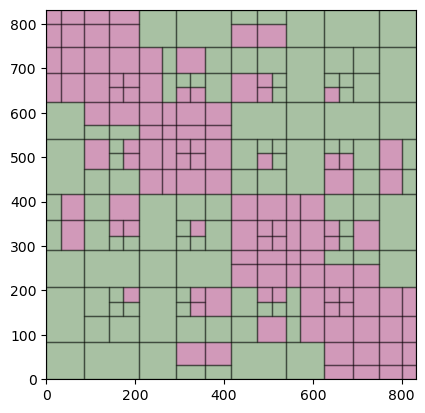

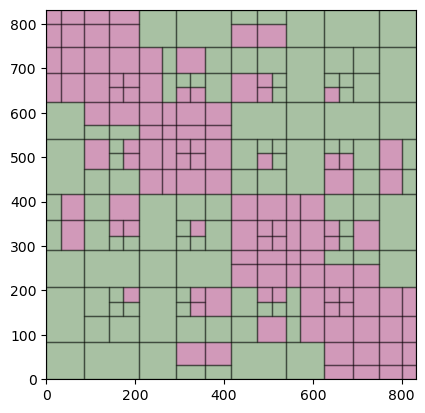

In [5]:
h.plotPattern()

In [6]:
# uniform tensile loads
f = np.zeros(h.shape_[0])
f[2::3]=1

In [7]:
from scipy.sparse.linalg import gmres

jac_ilu= h.H_ILU_prec() # we use a ILU decomposition of the full block for efficient solution via gmres
d = gmres(h,f,M=jac_ilu,tol=1e-6)[0]
d_global=d#h.convert_to_global(d)

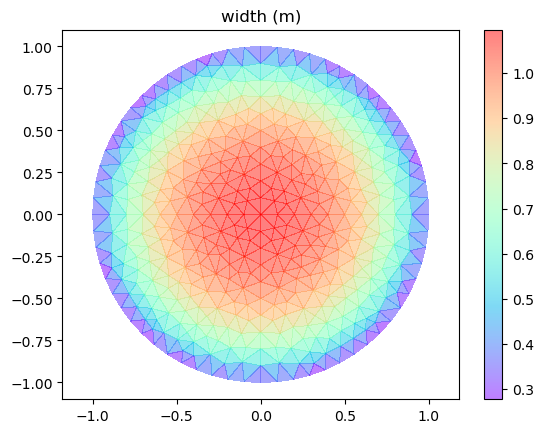

In [8]:

 
fig1, ax1 = plt.subplots()
tri=ax1.tripcolor(triang, d_global[2::3],cmap = plt.cm.rainbow, 
                    alpha = 0.5)
ax1.axis('equal')
plt.colorbar(tri) 
plt.title('width (m)')
plt.show()


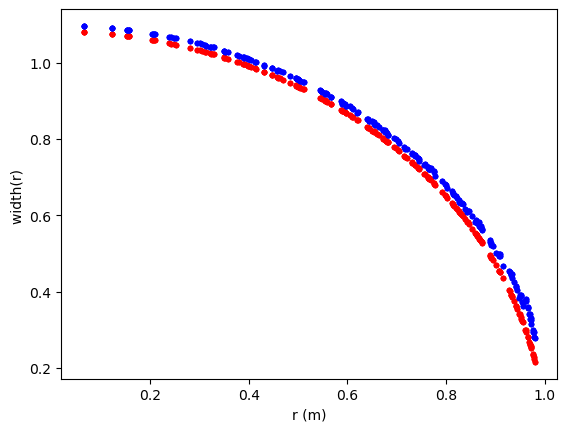

In [9]:
# collocation points - to compute analytical solutionm for width and then estimate stress & displacement at observations points
colpts=h.getCollocationPoints()
r_col = np.sqrt(colpts[:,0]**2+colpts[::,1]**2)
# Crack opening displacement discontinuity from analytical solution 
a=1
w = (4*(1-nu)/(G*np.pi))*np.sqrt(a**2-r_col**2)   

plt.plot(r_col,w,'.r')
plt.plot(r_col,d_global[2::3],'.b')
plt.xlabel('r (m)')
plt.ylabel('width(r) ')

abs_err =np.abs(w-d_global[2::3]) 
rel_err =np.abs(w-d_global[2::3])/w  

Text(0, 0.5, '$\\| w_{num}-w_{true} \\|$ ')

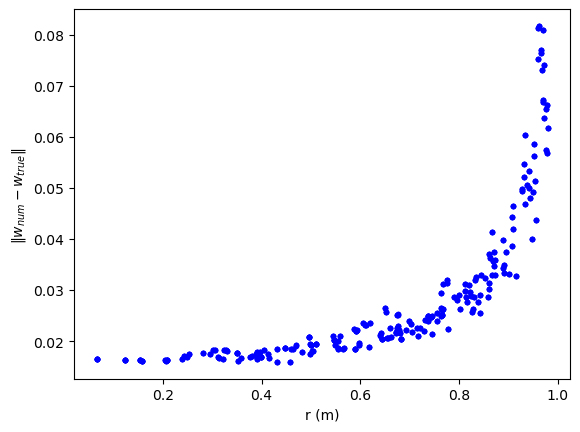

In [10]:
plt.plot(r_col,abs_err,'.b')
plt.xlabel('r (m)')
plt.ylabel('$\| w_{num}-w_{true} \|$ ')


In [11]:
# L2 norm of the error     $\|| w_{true}(r_i)-w_{num}(r_i)\||_2  / \||  w_{true}(r_i)\|
np.linalg.norm(abs_err)/np.linalg.norm(w)

0.042785881388013675

In [12]:
np.linalg.norm(rel_err) / conn.shape[0]

0.0031880898796448334